In [1]:
library(plyr)
source("../data/env/variables.R")
library(tidyverse)
library(magrittr)
require(cowplot)
library(ggstars)
options(repr.plot.width=10, repr.plot.height=8)
library(scales)
library(UpSetR)

options("readr.num_columns" = 0)

# convert to upper case the first word
proper=function(x) paste0(toupper(substr(x, 1, 1)), tolower(substring(x, 2)))

# read switches
switches.split <- read_tsv("../data/pancancer/candidateList_full.tumorSplit.tsv") %>%
    filter(Origin=="Tumor") %>%
    mutate(Reliable = as.numeric((NotNoise == 1) & (IsModel == 1) & (EnoughRecurrence == 1)))

switches <- read_tsv("../data/pancancer/candidateList_full.tsv") %>%
    filter(Reliable==1 & Origin=="Tumor")
    
potus <- switches %>%
    select(GeneId,Symbol,Normal_transcript,Tumor_transcript, Recurrence,
           Affects_mutated_feature,PPI,Pannegative,Candidate)

drivers <- read_tsv("../data/intogen_cancer_drivers-2014.12b/Mutational_drivers_per_tumor_type.tsv",comment="#") %>%
  mutate(Tumor_type = ifelse(Tumor_type=="COREAD", "coad", Tumor_type),
         Tumor_type = ifelse(Tumor_type=="HC", "lihc", Tumor_type),
         Tumor_type = ifelse(Tumor_type=="RCCC", "kirc", Tumor_type),
         Tumor_type = tolower(Tumor_type) ) %>%
  set_colnames(c("Symbol","Tumor")) %>%
  mutate(Driver=TRUE)

# read expression
proteome <- read_tsv("../data/mutations/proteome_information.txt") %>%
    set_colnames(c("Tumor","GeneId","Symbol","Transcript","TPM","ProteinLength","asEvidence")) %>%
    mutate(asEvidence = as.numeric(asEvidence=="True"))

# dictionary
id2symbol <- proteome %>%
    select(GeneId,Symbol) %>%
    unique

# protein features
features <- read_tsv("../data/mutations/proteome_features.txt") %>%
    filter(Analysis == "Pfam")

pf.all <- read_tsv("../results/pfam_enrichment_analysis.tsv")

switches.pfam <- read_tsv("../data/structural_analysis/interpro_analysis.tsv") %>%
    filter(What != "Kept") %>%
    group_by(Normal_transcript,Tumor_transcript) %>%
    summarise(DomainChange = unique(What) %>% paste0(collapse = ",")) %>%
    merge(switches.split, all.y=T)
    
# mutations
wes <- read_tsv("../data/mutations/wes_mutations.txt") %>%
    select(Tumor,GeneId,Symbol,Patient) %>%
    unique
    
# read interactions
ppi.network <- read_tsv("../data/eporta/raw_tables/interactions_found_more_than_three_times.txt", col_names = F) %>%
    select(-X3) %>%
    set_colnames(c("Gene1","Gene2")) %>%
    merge(id2symbol, by.x = "Gene1", by.y = "GeneId") %>%
    merge(id2symbol, by.x = "Gene2", by.y = "GeneId", suffixes = c("","2")) %>%
    set_colnames(c("Gene1","Gene2","Symbol1","Symbol2"))
    
ppi.file <- "../data/eporta/raw_tables/Switched_interactions_consensus.txt"

## get max number of columns (necessary for reading)
no_col <- max(count.fields(ppi.file,sep = "\t"))
no_col.ppi <- (no_col-6)/2
ppi.cols <- paste(c("Origin","Interaction"), floor(seq(1,no_col.ppi,0.5)), sep="_")

## read table
ppi.split <- read.table(ppi.file,header=F,fill=T,col.names=1:no_col) %>%
    set_colnames(c("GeneId","Symbol","Normal_transcript","Tumor_transcript","partnerId","partnerSymbol",ppi.cols)) %>%
    # all Origin columns contail "DDI_match", so we can disregard them
    select(-starts_with("Origin_")) %>%
    # convert from wide to long table format
    reshape2::melt(id.vars = c("GeneId","Symbol","Normal_transcript","Tumor_transcript","partnerId","partnerSymbol"),
                   value.name = "Interaction") %>%
    select(-variable) %>%
    # remove cases with no interaction described
    filter(Interaction != "") %>%
    # split interaction information
    separate(Interaction, into = c("What","partnerTranscript","Pfams"), sep = "-") %>%
    mutate(What = revalue(What, replace = c("Gained"="Gain", "Lost"="Loss", "Kept"="Unaffected"))) %>%
    # remove pfams columns (account for different domains for the same interaction)
    select(-Pfams) %>%
    # remove several instances of the same isoform
    unique %>%
    # annotate with switch info
    merge(switches.split %>% filter(Reliable==1)) %>%
    ## remove tumor specific measures
    select(-Recurrence,-Affects_mutated_feature,-PPI,-Pannegative) %>%
    merge(potus, by=c('GeneId','Symbol','Normal_transcript','Tumor_transcript','Candidate'), 
          suffixes=c(".split",".pancancer")) %>%
    # consider only the most abundant isoform as partner: one interaction per pair & only expressed genes
    merge(proteome, by.x = c("Tumor","partnerTranscript"), by.y = c("Tumor","Transcript"),
          suffixes = c(".switch",".partner"))
    
ppi <- ppi.split %>%
    group_by(GeneId.switch,Symbol.switch,Normal_transcript,Tumor_transcript,GeneId.partner,partnerSymbol) %>%
    summarise(Unaffected = sum(What=="Unaffected"), Gain = sum(What=="Gain"), Loss = sum(What=="Loss")) %>%
    ungroup() %>%
    set_colnames(c("GeneId","Symbol","Normal_transcript","Tumor_transcript",
                   "partnerGeneId","partnerSymbol","Unaffected","Gain","Loss")) %>%
    mutate(Tag = ifelse(Loss > 0, "Loss", "Unaffected"),
           Tag = ifelse(Gain > Loss, "Gain", Tag)) %>%
    merge(switches)

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
arrange():   dplyr, plyr
compact():   purrr, plyr
count():     dplyr, plyr
failwith():  dplyr, plyr
filter():    dplyr, stats
id():        dplyr, plyr
lag():       dplyr, stats
mutate():    dplyr, plyr
rename():    dplyr, plyr
summarise(): dplyr, plyr
summarize(): dplyr, plyr

Attaching package: ‘magrittr’

The following object is masked from ‘package:purrr’:

    set_names

The following object is masked from ‘package:tidyr’:

    extract

Loading required package: cowplot

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave


Attaching package: ‘scales’

The following object is masked from ‘package:purrr’:

    discard

The following objects are masked from ‘package:readr’:

    col_factor, col_numeric

Warnin

In [2]:
# Figure 1
## Figure 1a
f1a <- switches.split %>%
    filter(Reliable==1) %>%
    mutate(Driver = ifelse(Symbol %in% drivers$Symbol, "1", "0"),
           Driver = ifelse(Driver==1, "Driver", "Non-driver"),
           Driver = factor(Driver, levels=c("Non-driver","Driver")),
           IsFunctional = ifelse(IsFunctional==1, "Functional", "Non-functional"),
           Tumor = toupper(Tumor)) %>%
    ggplot(aes(x=Tumor, fill=IsFunctional, alpha=Driver)) +
        geom_bar() +
        labs(x="", y="# switches", fill="Switch", alpha="Gene") +
        scale_fill_manual(values=c("Functional"="firebrick", "Non-functional"="gray")) +
        scale_alpha_manual(values=c("Driver"=1, "Non-driver"=0.5)) +
        theme(axis.text.x = element_text(angle = 90, vjust = 0.3),
              legend.text=element_text(size=9),
              legend.title=element_text(size=10))

ggsave("../results/figures/components/1a.pdf",f1a)

Saving 7 x 7 in image


In [3]:
## Figure 1b
featsPalette = c("Gained in tumor" = "#91cf60", "Lost in tumor" = "#d6604d")

# read feature changes
structuralFeatures <- '../data/structural_analysis/structural_features.onlyModels.tsv' %>%
    read_tsv %>%
    # fix some tags
    mutate(Analysis = revalue(Analysis, c("iupred"="IUPRED",
                                          "anchor"="ANCHOR",
                                          "prosite"="ProSite"))) %>%
    ## get real switches
    filter(Random=="NonRandom") %>%
    # uniq switches from different tumors
    select(-Tumor) %>% unique %>%
    # count only reliable switches
    merge(switches %>% select(Normal_transcript, Tumor_transcript))

f1b <- structuralFeatures %>%
    filter(WhatsHappenning != "Nothing") %>%
    mutate(WhatsHappenning = gsub("_", " ", WhatsHappenning)) %>%
    ggplot(aes(Analysis, fill = WhatsHappenning)) + 
        geom_bar(position="dodge") + 
        labs(y = "Counts", x = "", fill = "") +
        scale_fill_manual(values = featsPalette) +
        theme(legend.position="bottom",
              legend.text=element_text(size=9),
              legend.title=element_text(size=10))

ggsave("../results/figures/components/1b.pdf", f1b)

Saving 7 x 7 in image


In [4]:
## Figure 1c
top.drivers <- switches %>%
    filter(Driver==1 & IsFunctional==1) %>%
    arrange(desc(PatientNumber)) %>%
    top_n(20, PatientNumber) %>%
    mutate(label = paste0(Symbol," (",Normal_transcript,",",Tumor_transcript,")")) %>%
    select(Normal_transcript,Tumor_transcript,label,Symbol)

f1c <- merge(top.drivers, switches.split) %>%
    mutate(label = factor(label, levels=top.drivers$label),
           Symbol = factor(Symbol, levels=top.drivers$Symbol),
           Tumor = toupper(Tumor)) %>%
    arrange(desc(Tumor)) %>%
    ggplot(aes(x=Symbol, y=PatientNumber, fill=Tumor)) +
        geom_bar(stat="identity") +
        labs(x="", y="# patients") +
        scale_fill_manual(values=colorPalette) +
        theme(axis.text.x = element_text(angle = 90, vjust = .5),
              legend.text=element_text(size=9),
              legend.title=element_text(size=10))

ggsave("../results/figures/components/1c.pdf", f1c)

Saving 7 x 7 in image


In [5]:
## Figure 1d
cc <- read_tsv("../results/pfam_go_term/losses_GO_cellular_component.tsv",skip=15) %>%
    mutate(type="Cellular component")
mf <- read_tsv("../results/pfam_go_term/losses_GO_molecular_function.tsv",skip=15) %>%
    mutate(type="Molecular function")

go <- do.call("rbind",list(cc,mf))  %>%
    set_colnames(c("group","id","goterm","slim_level","z","p","fdr","table","domains","type")) %>%
    mutate(goterm = proper(goterm),
           numSwitches = table %>% strsplit("|", fixed=T) %>% 
               lapply(function(x) as.numeric(x[1])) %>% unlist ) %>%
    arrange(desc(numSwitches)) %>%
    filter(slim_level == 2) %>%
    top_n(15) %>%
    mutate(# break lines longer than 40 chr
           # goterm = lapply(goterm, strwrap, width = 40)  %>% lapply(paste,sep="\n", collapse="\n") %>% unlist,
           goterm = factor(goterm, levels=goterm))
                   
f1d <- ggplot(go, aes(x = 1, y = goterm, alpha = numSwitches, fill = type, label = numSwitches)) +
        geom_tile() +
        geom_text(aes(x = 1, y = goterm, label = numSwitches), inherit.aes = F) +
        labs(x = "# switches", y = "GO term", fill = "Ontology") +
        theme(axis.line=element_blank(),axis.text.x=element_blank(),
              axis.ticks=element_blank(), axis.title.x=element_blank(),
              axis.text.y = element_text(size = 10), axis.title.y=element_blank(),
              legend.position="bottom",
              legend.text=element_text(size=9),
              legend.title=element_text(size=10)) +
        scale_alpha_continuous(guide=F) +
        scale_fill_manual(values = c("Cellular component"="firebrick", "Molecular function"="darkolivegreen2"), 
                          guide = guide_legend(nrow = 2, ncol = 2)) +
        scale_x_discrete(breaks=NULL)

ggsave("../results/figures/components/1d.pdf", f1d)

Selecting by numSwitches
Saving 7 x 7 in image


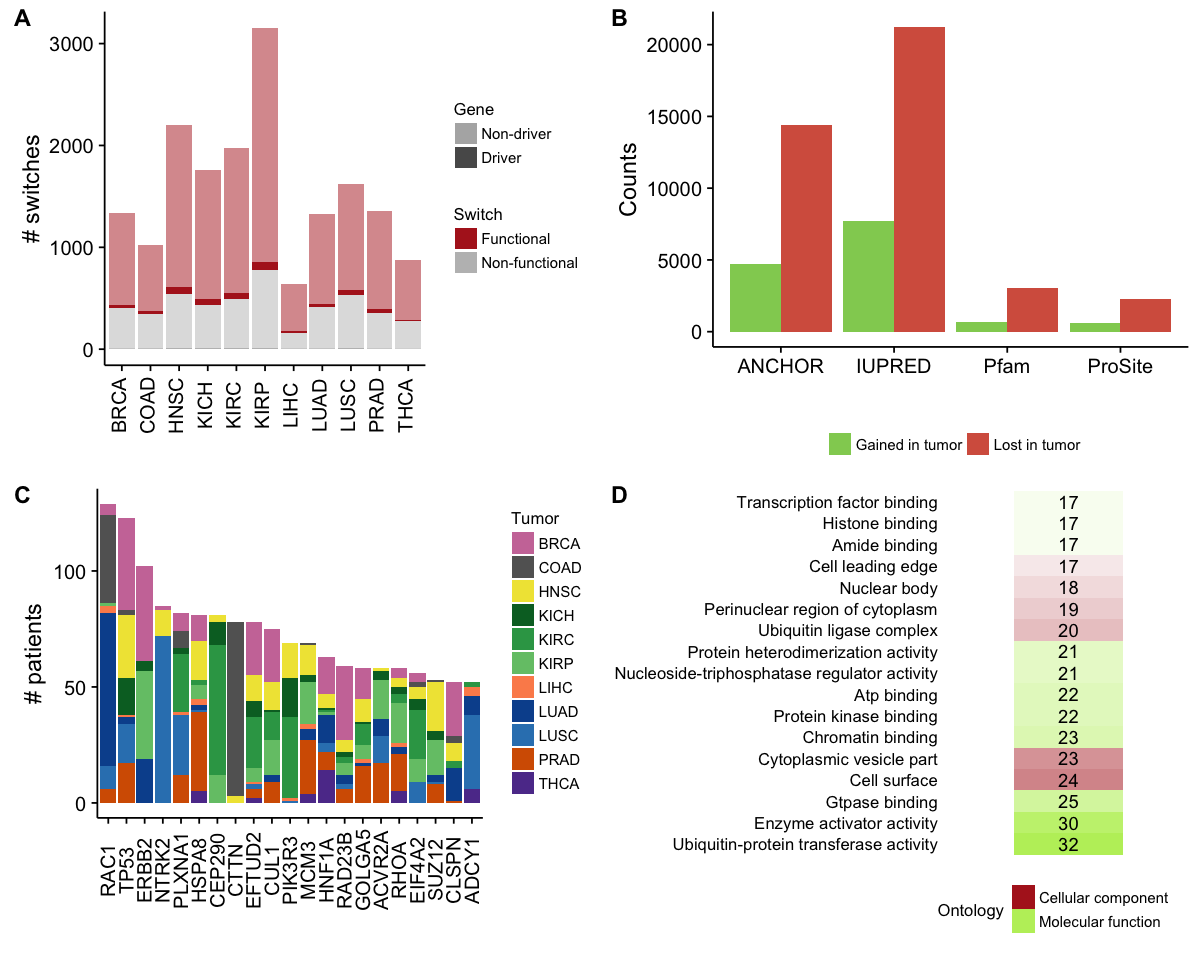

In [6]:
f1 <- plot_grid(f1a, f1b, f1c, f1d, labels=c("A","B","C","D"))
f1
ggsave("../results/figures/figure_1.pdf", f1, width = 10, height = 8)

**Figure 1. Patient-specific definition of isoform switches across multiple cancer types.** (A) Number of isoform switches (y axis) calculated in each tumor type, separated according to whether the switches affected an annotated protein feature (Functional) or not (Non-functional) and whether they occur in cancer gene drivers (Driver) or not (Non-driver). (B) Number of different protein feature gains and losses in functional switches for each of the protein annotations considered, which showed significant enrichment in losses compared to random switches: Pfam (Fisher’s exact test p-value = 4.4-23, odds-ratio (OR) = 1.5), Prosite (p-value = 1.4e-08, OR = 1.3), IUPRED (p-value = 1.1e-127, OR=1.3), ANCHOR (p-value = 7.5e-139, OR=1.5). (C) Top 20 functional switches in cancer drivers (x axis) according to patient count (y axis). Tumor types are indicated by color: breast carcinoma (BRCA), colon adenocarcinoma (COAD), head and neck squamous cell carcinoma (HNSC), kidney chromophobe (KICH), kidney renal clear-cell carcinoma (KIRC), kidney papillary cell carcinoma (KIRP), liver hepatocellular carcinoma (LIHC), lung adenocarcinoma (LUAD), lung squamous cell carcinoma (LUSC), prostate adenocarcinoma (PRAD), and thyroid carcinoma (THCA). (D) Cellular component (red) and Molecular function (green) ontologies associated with protein domain families that are significantly lost in functional isoform switches (Binomial test - BH adjusted p-value < 0.05). For each functional category, we give the number of switches in which a domain family from this category is lost, which is also indicated by the color shade.

In [7]:
# Figure 2
## Figure 2a
# count number of genes altered per patient
## WES mutation
genesPAM.perPatient <- wes %>%
    group_by(Tumor,Patient) %>%
    summarise(PAM=length(Patient))

## a functional switch
genesSwitched.perPatient <- switches$Patients_affected[switches$IsFunctional==1] %>%
    strsplit(",") %>% unlist %>%
    table %>% as.data.frame %>%
    set_colnames(c("Patient","Switch"))

# use number of spliced genes and total number of genes to normalize the observations
lines <- "Tumor\tSplicedGenes\tGenes\nbrca\t12383\t20530\nprad\t11849\t20530\nthca\t11812\t20530\ncoad\t11498\t20530\nhnsc\t11583\t20530\nkich\t11607\t20530\nkirc\t12205\t20530\nkirp\t11853\t20530\nlihc\t10490\t20530\nluad\t12046\t20530\nlusc\t12070\t20530\n"
consideredGenes <- read_tsv(lines) %>%
    set_colnames(c("Tumor","SplicedGenes","Genes"))

recurrence <- merge(genesSwitched.perPatient,genesPAM.perPatient,all=T) %>%
    merge(consideredGenes) %>%
    mutate(PAM=PAM/Genes, Switch=Switch/SplicedGenes) %>%
    select(everything(),-contains("Genes"))

# show lack of correlation between mutations and switches
f2a <- recurrence %>%
    mutate(Tumor = toupper(Tumor)) %>% 
    ggplot(aes(x=Switch,y=PAM)) + 
        geom_point(aes(color=Tumor), alpha = 0.5) + 
        scale_color_manual(values=colorPalette) + 
        labs(x="Genes with a functional switch", y="Genes with a PAM") +
        scale_y_continuous(labels = percent) +
        scale_x_continuous(labels = percent) +
        theme(legend.text=element_text(size=9),
              legend.title=element_text(size=10))

ggsave("../results/figures/components/2a.pdf", f2a)

Saving 7 x 7 in image
Warning message:
“Removed 180 rows containing missing values (geom_point).”

In [8]:
## Figure 2b
losses <- !is.na(pf.all$adjp_l) &pf.all$adjp_l < 0.05 # & pf.all$switches_l > 1
gains <- !is.na(pf.all$adjp_g) & pf.all$adjp_g < 0.05 # & pf.all$switches_g > 1
mut <- !is.na(pf.all$adjp_m) & pf.all$adjp_m < 0.05

MS.pfams <- pf.all %>%
    mutate(What = ifelse(gains,"Gains","undecided"),
           What = ifelse(losses,"Losses",What),
           What = ifelse(losses & gains,"Both",What),
           switches_g = ifelse(gains, switches_g, 0),
           switches_l = ifelse(losses, switches_l, 0),
           NumSwitches = apply(cbind(switches_g, switches_l),1,max),
           NumSwitchesLabel = ifelse(What == "Both", paste0(switches_g,"/",switches_l), NumSwitches)) %>%
    select(Feature, What, NumSwitches,NumSwitchesLabel) %>%
    filter((losses | gains) & mut) %>%
    mutate(Feature = unlist(strsplit(Feature,"|", fixed=T))[c(F,T)],
           Feature = gsub("_"," ",Feature),
           What = factor(What, levels=c("Losses","Both","Gains")))

f2b <- MS.pfams %>%
    mutate(NumSwitches = ifelse(What=="Losses", NumSwitches, -NumSwitches)) %>%
    arrange(NumSwitches) %>%
    mutate( Feature = factor(Feature, levels = unique(Feature))) %>%
    ggplot(aes(y=Feature, fill = What, alpha = abs(NumSwitches), label = NumSwitchesLabel)) +
        geom_tile(aes(x=1), stat="identity") +
        geom_text(aes(x=1), color="black", size=3.5, alpha=1) +
        scale_fill_manual(values = c("Gains" = "#e08214", "Losses" = "#8073ac", "Both" = "darkolivegreen2")) +
        facet_grid(What~., scales="free",drop=T,space="free") +
        theme(axis.line=element_blank(),axis.text.x=element_blank(),
              axis.ticks=element_blank(), axis.title.x=element_blank(),
              axis.text.y = element_text(size=9), axis.title.y=element_blank(),
              legend.position="none")

ggsave("../results/figures/components/2b.pdf", f2b)

Saving 7 x 7 in image


In [9]:
## Figure 2c
# Read pfam annotation
pfam2go <- read_tsv("../data/PFAM2GO.txt",skip=1)
go.levels <- read_tsv("../data/PFAMGO.txt",skip=1)

pfam2go.m <- merge(pfam2go,go.levels) 

# Get list of all observed domains with their associated annotation
domains <- dlply(pfam2go.m, .(slim_level,GO_subontology,GO_ID), function(x){
    intersect(pf.all$id, unlist(strsplit(x[,3],",")))
}) %>% unlist 
class <- gsub("\\.[^\\.]+$", "", names(domains))

expressedgos <- unlist(strsplit(names(domains), ".", fixed=T))[c(F,F,T)] %>% 
    substr(1,10) %>%
    split(class) %>%
    lapply(unique)

# read GO term enrichment analysis
## molecular function
smf <- read_tsv("../results/pfam_go_term/S_GO_molecular_function.tsv",skip=15) %>%
    mutate(origin="switches", gotype="molecular_function")
mmf <- read_tsv("../results/pfam_go_term/M_GO_molecular_function.tsv",skip=15) %>%
    mutate(origin="mutations", gotype="molecular_function")

## cellular component
scc <- read_tsv("../results/pfam_go_term/S_GO_cellular_component.tsv",skip=15) %>%
    mutate(origin="switches", gotype="cellular_component")
mcc <- read_tsv("../results/pfam_go_term/M_GO_cellular_component.tsv",skip=15) %>%
    mutate(origin="mutations", gotype="cellular_component")

## join them
go <- do.call("rbind", list(smf, mmf, scc, mcc)) %>%
    set_colnames(c("group", "id", "goterm", "slim_level", "z", "p",
                   "fdr", "table", "domains", "origin", "gotype")) 

# calculate an agreement between M and S
## for each go type (CC and MF) and GO slim level
## calculate the number of domains affected by both M and S (Match) and the total (Any)
all <- go %>%
    count(id, gotype, slim_level) %>%
    group_by(gotype, slim_level) %>%
    summarise(Match = sum(n == 2), Any = n())

## calculate the number of domains affected only by M (M)
M <- go %>% 
    filter(origin == "mutations") %>%
    count(gotype, slim_level) %>%
    mutate(M = n) %>%
    select(-n)

## calculate the number of domains affected only by S (S)
S <- go %>% 
    filter(origin == "switches") %>%
    count(gotype, slim_level) %>%
    mutate(S = n) %>%
    select(-n)

## merge all and create an appropriate dataframe
coincidence <- merge(all, M) %>%
    merge(S) %>%
    mutate(Match = Match/Any, 
           sdMatch = NA, 
           Coincidence = "Observed", 
           slim_level = revalue(as.character(slim_level),
                                replace = c('1'="Least Informative", 
                                            '2'="Moderately Informative",
                                            '3'="Informative", 
                                            '4'="Highly Informative")))

# simulate data to calculate statistical significance
## prepare df to get sample sizes required by S and M
permutationInfo <- unique(coincidence[,c('gotype','slim_level',"M","S")])

## we will study the significance for each GO type + slim level (GO LEVEL)
random_coincidence <- lapply(names(expressedgos), function(c){
    # get GO type and slim level of the GO LEVEL
    studied_level <- strsplit(c, "\\.") %>% unlist
    this.slim_level <- studied_level[1]
    this.gotype <- studied_level[2]

    # get the match for that GO LEVEL for p-value calculation later
    real_match <- coincidence %>% 
        filter(slim_level == this.slim_level & gotype == this.gotype) %>% 
        .$Match
    
    # check if the GO LEVEL has been surveyed
    v <- paste(permutationInfo$slim_level, permutationInfo$gotype, sep = ".") == c
    if (sum(v) > 0){
        x <- permutationInfo %>% 
            filter(slim_level == this.slim_level & gotype == this.gotype)
        # 100 permutations
        # sample the expressed go terms at that GO LEVEL
        # measure the intersection
        permutations <- lapply(1:100, function(i){
            m <- sample(expressedgos[[c]], x$M)
            s <- sample(expressedgos[[c]], x$S)
            length(intersect(m,s))/length(unique(c(m,s)))
        }) %>% do.call("c", .)
        
        # empirical distribution for p-value calculation
        f <- ecdf(permutations)

        data.frame(gotype = this.gotype, 
                   slim_level = this.slim_level, 
                   Match = mean(permutations), 
                   sdMatch = sd(permutations),
                   p = 1 - f(real_match), 
                   Coincidence = "Random (x100)")
    }
}) %>% do.call("rbind", .)
        
# capitalize first letter
firstup <- function(x) {
   substr(x, 1, 1) <- toupper(substr(x, 1, 1))
    x
}

p <- random_coincidence$p
gg <- coincidence %>%
    select(gotype, slim_level, Match, sdMatch, Coincidence) %>%
    rbind(random_coincidence %>% select(-p)) %>%
    mutate(slim_level = factor(revalue(slim_level, 
                                       replace = c('Least Informative' = "+", 
                                                   'Moderately Informative' = "++",
                                                   'Informative' = "+++", 
                                                   'Highly Informative' = "++++")),
                                       levels = c('+','++','+++','++++')),
           gotype = gsub("_"," ",gotype),
           gotype = firstup(gotype)) %>%
    ggplot(aes(x = slim_level, y = Match, fill = gotype, alpha = Coincidence)) +
        geom_bar(position = "dodge", stat = "identity") +
        geom_errorbar(aes(ymax = Match + sdMatch, ymin = Match - sdMatch), position = "dodge") +
        scale_alpha_discrete(range = c("Observed" = 1, "Random (x100)" = 0.5)) +
        labs(x = "Information", y = "Switch/mutation agreement", fill = "GO Ontology") +
        theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
        scale_y_continuous(labels = percent) +
        ylim(0, 0.85)

f2c <- star_bar(gg, p < 0.05, arc.radius = 0.18, arc.separation = 0.025, size = 7)
ggsave("../results/figures/components/2c.pdf", f2c)

The following `from` values were not present in `x`: 4
The following `from` values were not present in `x`: Highly Informative
Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.
Saving 7 x 7 in image
Warning message:
“Removed 8 rows containing missing values (geom_errorbar).”

In [10]:
## Figure 2d
me <- read_tsv("../results/supplementary_files/supplementary_file_3.tsv") %>%
    filter(p_mut_ex < 0.05 & Number_ME_drivers > 2 & p_me_pathway_driver < 0.05) %>%
    select(Tumor, GeneId, Symbol, Normal_transcript, Tumor_transcript)

# read mutual exclusion with specific drivers
me.specificDrivers <- read_tsv("../data/mutations/mutual_exclusion_top_drivers.txt") %>%
    mutate(Total = M + MS + S + N, 
           M.p = M/Total, 
           MS.p = MS/Total,
           S.p = S/Total, 
           N.p = N/Total) %>%
    mutate(Tumor = toupper(Tumor)) %>%
    merge(me)

potus.pn <- switches %>%
    filter(Candidate==1 & Pannegative > 0 & Origin=="Tumor") %>%
    merge(me.specificDrivers, by=c("GeneId","Symbol","Normal_transcript","Tumor_transcript")) %>%
    filter(p.me < 0.05 & Pathway!="")

f2d <- switches %>%
    filter(Candidate == 1 & Pannegative > 0 & Origin=="Tumor") %>%
    merge(me.specificDrivers, by=c("GeneId","Symbol","Normal_transcript","Tumor_transcript")) %>%
    filter(p.me < 0.05 & Pathway!="") %>%
    mutate(Tumor = toupper(Tumor)) %>%
    ggplot(aes(x = MS.p + M.p, y = MS.p + S.p, color = Tumor)) + 
        geom_point(size=0.8) +
        geom_text(data=subset(potus.pn, MS.p+S.p > 0.02), aes(label=paste0(Symbol," (",DriverSymbol,")")),
                   vjust = "inward", hjust = "inward", check_overlap = T) +
        labs(x="Mutated samples", y="Switched samples") +
        scale_color_manual(values=colorPalette) +
        guides(col = guide_legend(override.aes = list(shape = 15, size = 5))) +
        scale_y_continuous(labels = percent) +
        scale_x_continuous(labels = percent) +
        theme(legend.text=element_text(size=9),
              legend.title=element_text(size=10))

ggsave("../results/figures/components/2d.pdf", f2d)

Saving 7 x 7 in image


Warning message:
“Removed 180 rows containing missing values (geom_point).”Warning message:
“Removed 8 rows containing missing values (geom_errorbar).”

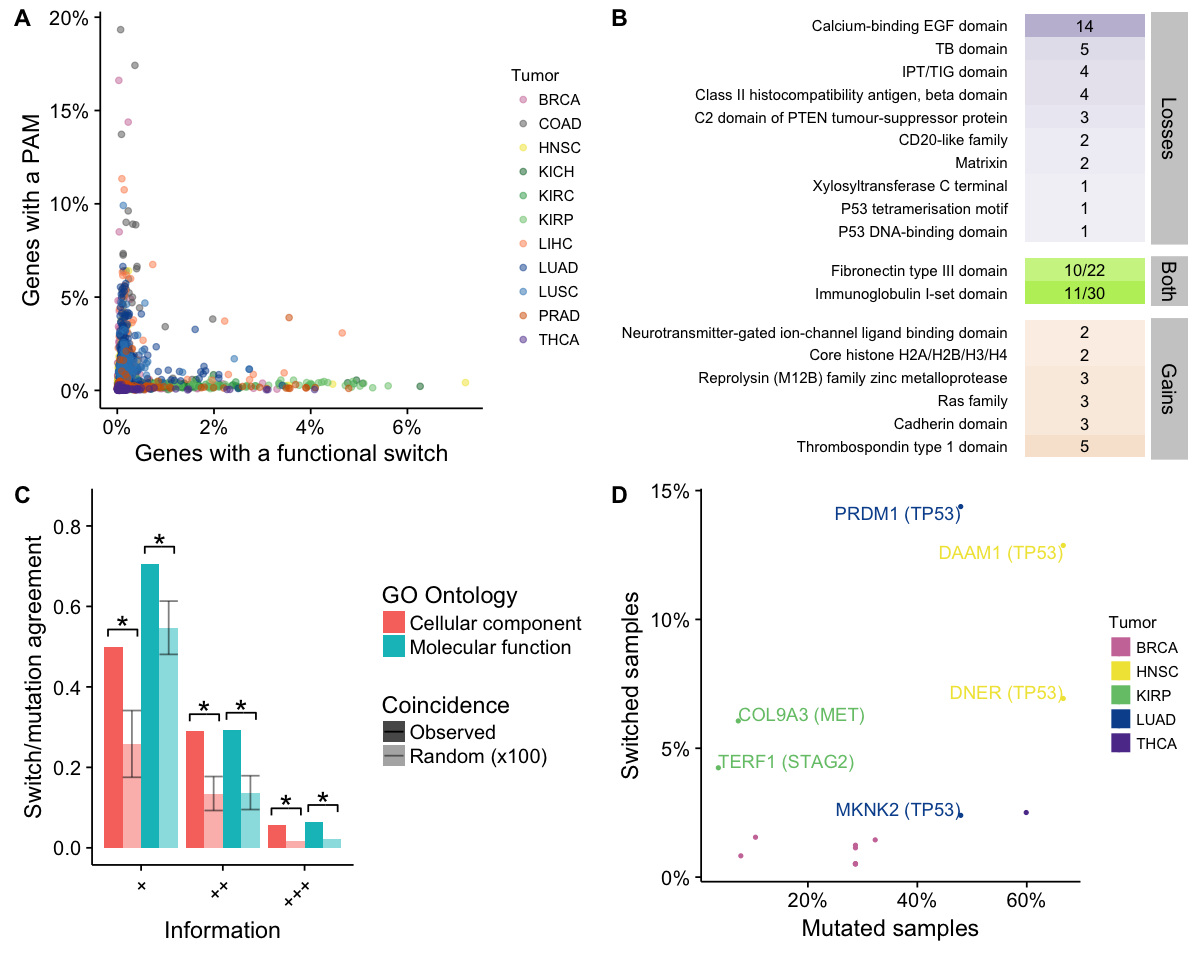

In [11]:
f2 <- plot_grid(f2a, f2b, f2c, f2d, labels=c("A","B","C","D"))
f2
ggsave("../results/figures/figure_2.pdf", f2, width = 10, height = 8)

**Figure 2. Comparison of isoform switches and somatic mutations.** (A) For each patient sample, color-coded according to the tumor type, we indicate the proportion of all genes with protein-affecting mutations (PAMs) (y axis) and the proportion of genes with multiple transcript isoforms that present a functional isoform switch in the same sample (x axis). (B) Domain families that are significantly lost or gained in functional isoform switches that are also significantly enriched in protein-affecting mutations in tumors. For each domain class, we indicate the number of different switches in which they occur. We include here the loss of the P53 DNA-binding and P53 tetramerization domains, which only occurred TP53. (C) Agreement between protein-affecting mutations and functional switches (y axis) measured in terms of the functional categories of the protein domains they affect (x axis), using two gene ontologies (GOs) at three different GO Slim levels, from most specific (+++) to least specific (+). Random occurrences (plotted in light color) were calculated by sampling 100 times the same number of domain families affected by functional switches and the same number of domains affected by protein-affecting mutations. Agreement is calculated as the percentage of the union of functional categories that are common to both sets. (D) Pairs formed by a cancer driver (in parentheses) and a functional switch that belong to the same pathway and show significant mutual exclusion (before multiple test correction) between PAMs and switches across patients in at least one tumor type –color-coded by tumor type. The y-axis indicates the percentage of samples where the switch occurs and x-axis indicates the percentage of samples where the driver is mutated in the same tumor type.

In [12]:
# Figure 3
ppiPalette = c("Gain" = "#91cf60", "Loss" = "#d6604d", 
               "Unaffected" = "#d9d9d9", "Draw" = "#ffffbf")

## Figure 3a
f3a <- ppi.split %>%
    mutate(SpecificDriver = ifelse(SpecificDriver==1, "Yes", "No"),
           Tumor = toupper(Tumor)) %>%
    ggplot(aes(x=SpecificDriver, fill=What)) + 
        geom_bar(position="fill") +
        labs(x="Tumor-specific driver",y="Described PPIs",fill="Effect of the switch") +
        scale_fill_manual(values = ppiPalette) +
        scale_y_continuous(labels = percent) +
        facet_grid(.~Tumor) +
        theme(legend.position="bottom", axis.text.x = element_text(angle = 90, vjust = 0.3),
              strip.text.x = element_text(size = 6),
              legend.text=element_text(size=9),
              legend.title=element_text(size=10))

ggsave("../results/figures/components/3a.pdf", f3a)

Saving 7 x 7 in image


In [13]:
## Figure 3b
driver.ppi.network <- ppi.network %>%
    filter(Symbol1 %in% drivers$Symbol | Symbol2 %in% drivers$Symbol)

d1 <- lapply(cancerTypes, function(tumor){
    tumor.drivers <- drivers %>%
        filter(Tumor == tumor)
    
    driver.ppi.network %>%
        mutate(Symbol1 = ifelse(Symbol1 %in% tumor.drivers$Symbol, "", Symbol1),
               Symbol2 = ifelse(Symbol2 %in% tumor.drivers$Symbol, "", Symbol2)) %>%
        # get cases with one driver
        filter(Symbol1 == "" | Symbol2 == "") %>%
        # remove cases with two drivers
        filter(Symbol1 != "" | Symbol2 != "") %>%
        mutate(Symbol = paste0(Symbol1, Symbol2),
               Tumor = tumor, d1 = TRUE) %>%
        select(Symbol, Tumor, d1)
}) %>% do.call("rbind",.)

f3b <- ppi.split %>% 
    filter(Reliable == 1) %>%
    select(Tumor, Symbol.switch, Normal_transcript, Tumor_transcript, SpecificDriver, PPI) %>%
    merge(d1, all.x = T, by.x = c("Tumor", "Symbol.switch"), by.y = c("Tumor", "Symbol")) %>%
    mutate(d1 = ifelse(is.na(d1), FALSE, d1),
           Gene = ifelse(d1,"Driver interactor","Other"),
           Gene = ifelse(SpecificDriver == 1, "Driver", Gene),
           PPI = ifelse(PPI == 1, "Yes", "No"),
           Tumor = toupper(Tumor)) %>%
    select(Tumor, Gene, PPI) %>%
    ggplot(aes(x = PPI, fill = Gene)) +
        geom_bar(position = "fill") +
        labs(y = "Switches", x = "Affects PPI") +
        scale_y_continuous(labels = percent) +
        scale_fill_manual(values = c("Driver" = "black", "Driver interactor" = "gray70", "Other" = "gray90")) +
        facet_grid(.~Tumor) +
        theme(legend.position = "bottom", 
              axis.text.x = element_text(angle = 90, vjust = 0.4),
              strip.text.x = element_text(size = 6),
              legend.text=element_text(size=9),
              legend.title=element_text(size=10))

ggsave("../results/figures/components/3b.pdf", f3b)

Saving 7 x 7 in image


In [14]:
## Figure 3c
source("../data/env/getPPINetwork.R")
library(ggnetwork)

SPLICEOSOME <- c("CNBP","IPO13","RSL1D1","HNRNPU","HNRNPF","UBE2E3","DHX15","NHP2L1","RBM39",
             "RBMX","RBM11","TARDBP","EEF1A1","EEF1D","DDX5","PABPC1","UBE2E1","SFRS6",
             "HNRNPD","CHD1","RBM7","SYNCRIP","EEF1A2","PSPC1","SFRS11","HNRNPR","MAPK9",
             "CLK3","RNF167","GAS7","SUMO1","HNRNPA1","SF1","RBM25","SFRS4","MYB","BMPR1A",
             "TRA2B","HNRNPC","RBMS2","SFRS7","RPL31","WBP4","SFRS13A","PTBP1","HNRNPM",
             "SNRNP70","SNRPA","EWSR1","TDRD3","RNPS1","SFRS1","ZMYND11","NUDT21","CDK11B",
             "VARS","BTRC","CPSF6","ELAVL1","NXT1","PRPF8","NUP98","PRPF4","SFRS3","NXF1","SAE1",
             "RBM41","HNRNPA0","SUMO2","SFRS9","SF3B4","YBX1","SRPK1","RAN","HNRPDL","MKI67IP","THOC4",
             "TCERG1","U2AF2","EIF4H","FBL","MAGOH","HNRNPH1","SFPQ","SUMO3","SFRS5","TNPO1","NUP133",
             "UBA2","FUS","HNRNPA3","DDX17","SFRS2","PUF60","IPO11","THRA","HNRNPA2B1","PCBP1","SF3B1",
             "UBE2I","CDK19","EIF6","TNPO3","SNRPD2","CIRBP","TRA2A","RBBP6","NONO","TNPO2","SF3B2",
             "DUSP11","U2AF1","SF3B14","SFRS12","NUTF2","KPNA3","SNRPB2","KHDRBS2")
SPLICEOSOME <- id2symbol %>%
    filter(Symbol %in% SPLICEOSOME) %>%
    .$GeneId

currentSymbols <- c('IPO13','NXF1','TDRD3','HNRNPC','RNPS1','FUS','THRA','SFRS1','PTBP1',
                    'SNRPB2','NHP2L1','UBE2E1','CNBP','TRA2B','HNRNPD','IPO11','HNRNPH1',
                    'SYNCRIP','PUF60','PRPF4','RBM41','DDX5','SF1','RBMS2','SFRS2','SRPK1',
                    'TRA2A','PABPC1','RBMX')
ppi.filt <- ppi %>%
    filter(Symbol %in% currentSymbols)

nw <- getPPINetwork(SPLICEOSOME, ppi.network, ppi.filt)

# add node attributes
nw %v% "Gene" <- ifelse(nw %v% "vertex.names" %in% ppi.filt$Symbol, "Switch", "Non-switch")
nw %v% "Gene" <- ifelse(nw %v% "vertex.names" %in% drivers$Symbol, 
                        paste0(nw %v% "Gene", " driver"), paste0(nw %v% "Gene", " non-driver"))

f3c <- ggplot(nw, aes(x = x, y = y, xend = xend, yend = yend)) +
    geom_edges(aes(color = Effect, linetype = Consensus)) +
    geom_nodelabel(aes(label = vertex.names, fill = Gene), size = 3, color = "white") +
    scale_color_manual(values = ppiPalette) +
    scale_fill_manual(values = c("Switch driver" = "#404040", "Non-switch driver" = "#bababa",
                                 "Switch non-driver" = "#2c7bb6", "Non-switch non-driver" = "#abd9e9"),
                      guide = guide_legend(nrow = 2, ncol = 2)) +
    scale_linetype_manual(values = c("Yes" = "solid", "No" = "dashed"), guide = "none") +
    lims( x = c(-.10, 1.10)) + 
    theme(axis.line=element_blank(),axis.text.x=element_blank(),
          axis.text.y=element_blank(),axis.ticks=element_blank(),
          axis.title.x=element_blank(),axis.title.y=element_blank(),
          legend.position="bottom",
          legend.text=element_text(size=9),
          legend.title=element_text(size=10)) +
    guides(color = FALSE)

ggsave("../results/figures/components/3c.pdf", f3c)

network: Classes for Relational Data
Version 1.13.0 created on 2015-08-31.
copyright (c) 2005, Carter T. Butts, University of California-Irvine
                    Mark S. Handcock, University of California -- Los Angeles
                    David R. Hunter, Penn State University
                    Martina Morris, University of Washington
                    Skye Bender-deMoll, University of Washington
 For citation information, type citation("network").
 Type help("network-package") to get started.


Attaching package: ‘network’

The following object is masked from ‘package:plyr’:

    is.discrete


Attaching package: ‘igraph’

The following objects are masked from ‘package:network’:

    %c%, %s%, add.edges, add.vertices, delete.edges, delete.vertices,
    get.edge.attribute, get.edges, get.vertex.attribute, is.bipartite,
    is.directed, list.edge.attributes, list.vertex.attributes,
    set.edge.attribute, set.vertex.attribute

The following object is masked from ‘package:magrittr’

In [15]:
## Figure 3d
source("../data/env/getAffected.R")
library(find.me)

# filter out patients without RNAseq data available
rnaseqPatients <- strsplit(switches$Patients_affected,",") %>% unlist %>% unique
mutations <- wes %>%
  filter(Patient %in% rnaseqPatients) %>%
  mutate(Alteration2="MUT")

pannegative <- merge(wes,drivers,all.x=T) %>%
  mutate(Driver = ifelse(is.na(Driver), FALSE, TRUE)) %>%
  group_by(Patient) %>%
  summarise(Pannegative = ifelse(sum(Driver), "Mut+", "Mut-"))

# mutations in drivers
driver.mutations <- mutations %>%
  filter(Symbol %in% drivers$Symbol)

SPLICEOSOME.net <- nw %v% "vertex.names"

ppi.onco <- ppi.filt %>%
    group_by(GeneId, Symbol, Normal_transcript, Tumor_transcript) %>%
    summarise(PPIChange = unique(Tag) %>% paste(collapse = ",")) %>%
    merge(switches.split %>% filter(Symbol %in% currentSymbols), all.y = T) %>%
    mutate(PPIChange = ifelse(is.na(PPIChange), "Unaffected", PPIChange))

affected <- getAffected(SPLICEOSOME.net, ppi.onco, driver.mutations)
affectedWide <- affected$wide
affectedLong <- affected$long

ngenes_3d <- nrow(affectedWide)
# SPLICING: amp for losses, del for gains, down for any functional
plot.colors <- c(colorPalette, "amp" = "#f03b20", "del" = "#31a354", "downreg" = "gray70", 
                 "somatic" = "#36454F", "Mut+" = "black", "Mut-" = "gray80", "MutUnknown"="white")

patients <- affectedLong %>% 
  select(Tumor,Patient) %>%
  unique %>%
  merge(pannegative,all.x=T) %>%
  mutate(Pannegative = ifelse(is.na(Pannegative), "MutUnknown", Pannegative))

f3d <- oncoprint(affectedWide) + 
  geom_tile(data = patients, aes(x = Patient,y = ngenes_3d + .75, fill = Tumor), height=0.3) +
  geom_tile(data = patients, aes(x = Patient, y = ngenes_3d + .55, fill = as.character(Pannegative)), height=0.1) +
  labs(x="", y="") + 
  theme(axis.text.x=element_blank(), 
        # remove grid 
        panel.grid.major = element_blank(), panel.grid.minor = element_blank()) + 
  scale_fill_manual(values = plot.colors)
  
ggsave("../results/figures/components/3d.pdf", f3d)

Loading required package: reshape2

Attaching package: ‘reshape2’

The following object is masked from ‘package:tidyr’:

    smiths

Warning message:
“Ignoring unknown aesthetics: width, height”Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.
Saving 7 x 7 in image


In [16]:
## Figure 3e
post.splicing <- c("EEF1A1","PABPC1","EIF1","EIF2B1","EIF2B2","EIF2B3","EIF2B4","EIF2B5",
                   "EIF2S1","EIF2S2","EIF2S3","EIF3A","EIF3B","EIF3C","EIF3D","EIF3E","EIF3F",
                   "EIF3G","EIF3H","EIF3I","EIF3J","EIF4A2","EIF4A3","EIF4B","EIF4E",
                   "EIF4EBP1","EIF4G1","EIF5","EIF5B")
post.splicing <- id2symbol %>%
    filter(Symbol %in% post.splicing) %>%
    .$GeneId

currentSymbols <- c("EIF3A","EIF4B","EIF5","EIF3C","EIF2B4","EIF2B5","EIF4A2",
                    "EEF1A1","EIF3B","PABPC1","EIF3E","EIF4A3","EIF4E")
ppi.filt <- ppi %>%
    filter(Symbol %in% currentSymbols)

nw <- getPPINetwork(post.splicing, ppi.network, ppi.filt)

# add node attributes
nw %v% "Gene" <- ifelse(nw %v% "vertex.names" %in% ppi.filt$Symbol, "Switched", "Unswitched")
nw %v% "Gene" <- ifelse(nw %v% "vertex.names" %in% drivers$Symbol, 
                        paste0(nw %v% "Gene", " driver"), paste0(nw %v% "Gene", " non-driver"))

f3e <- ggplot(nw, aes(x = x, y = y, xend = xend, yend = yend)) +
    geom_edges(aes(color = Effect, linetype = Consensus)) +
    geom_nodelabel(aes(label = vertex.names, fill = Gene), size = 5, color = "white") +
    scale_color_manual(values = ppiPalette) +
    scale_fill_manual(values = c("Switched driver" = "#404040", "Unswitched driver" = "#bababa",
                                 "Switched non-driver" = "#2c7bb6", "Unswitched non-driver" = "#abd9e9"),
                      guide = guide_legend(nrow = 2, ncol = 2)) +
    scale_linetype_manual(values = c("Yes" = "solid", "No" = "dashed"), guide = "none") +
    lims( x = c(-.10, 1.10)) + 
    theme(axis.line=element_blank(),axis.text.x=element_blank(),
          axis.text.y=element_blank(),axis.ticks=element_blank(),
          axis.title.x=element_blank(),axis.title.y=element_blank(),
          legend.text=element_text(size=9),
          legend.title=element_text(size=10),
          legend.position="bottom") +
    guides(color = FALSE)

ggsave("../results/figures/components/3e.pdf", f3e)

Saving 7 x 7 in image


In [17]:
## Figure 3f
post.splicing.net <- nw %v% "vertex.names"

ppi.onco <- ppi.filt %>%
    group_by(GeneId, Symbol, Normal_transcript, Tumor_transcript) %>%
    summarise(PPIChange = unique(Tag) %>% paste(collapse = ",")) %>%
    merge(switches.split %>% filter(Symbol %in% currentSymbols), all.y = T) %>%
    mutate(PPIChange = ifelse(is.na(PPIChange), "Unaffected", PPIChange))

affected <- getAffected(post.splicing.net, ppi.onco, driver.mutations)
affectedWide <- affected$wide
affectedLong <- affected$long

affectedLong <- affectedLong %>%
    filter(Patient %in% colnames(affectedWide))

ngenes_3f <- nrow(affectedWide)

patients <- affectedLong %>% 
  select(Tumor,Patient) %>%
  unique %>%
  merge(pannegative,all.x=T) %>%
  mutate(Pannegative = ifelse(is.na(Pannegative), "MutUnknown", Pannegative))

f3f <- oncoprint(affectedWide) + 
  geom_tile(data = patients, aes(x = Patient,y = ngenes_3f + .75, fill = Tumor), height=0.3) +
  geom_tile(data = patients, aes(x = Patient, y = ngenes_3f + .55, fill = as.character(Pannegative)), height=0.1) +
  labs(x="", y="") + 
  theme(axis.text.x=element_blank(), 
        # remove grid 
        panel.grid.major = element_blank(), panel.grid.minor = element_blank()) + 
  scale_fill_manual(values = plot.colors)

ggsave("../results/figures/components/3f.pdf", f3f)

Warning message:
“Ignoring unknown aesthetics: width, height”Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.
Saving 7 x 7 in image


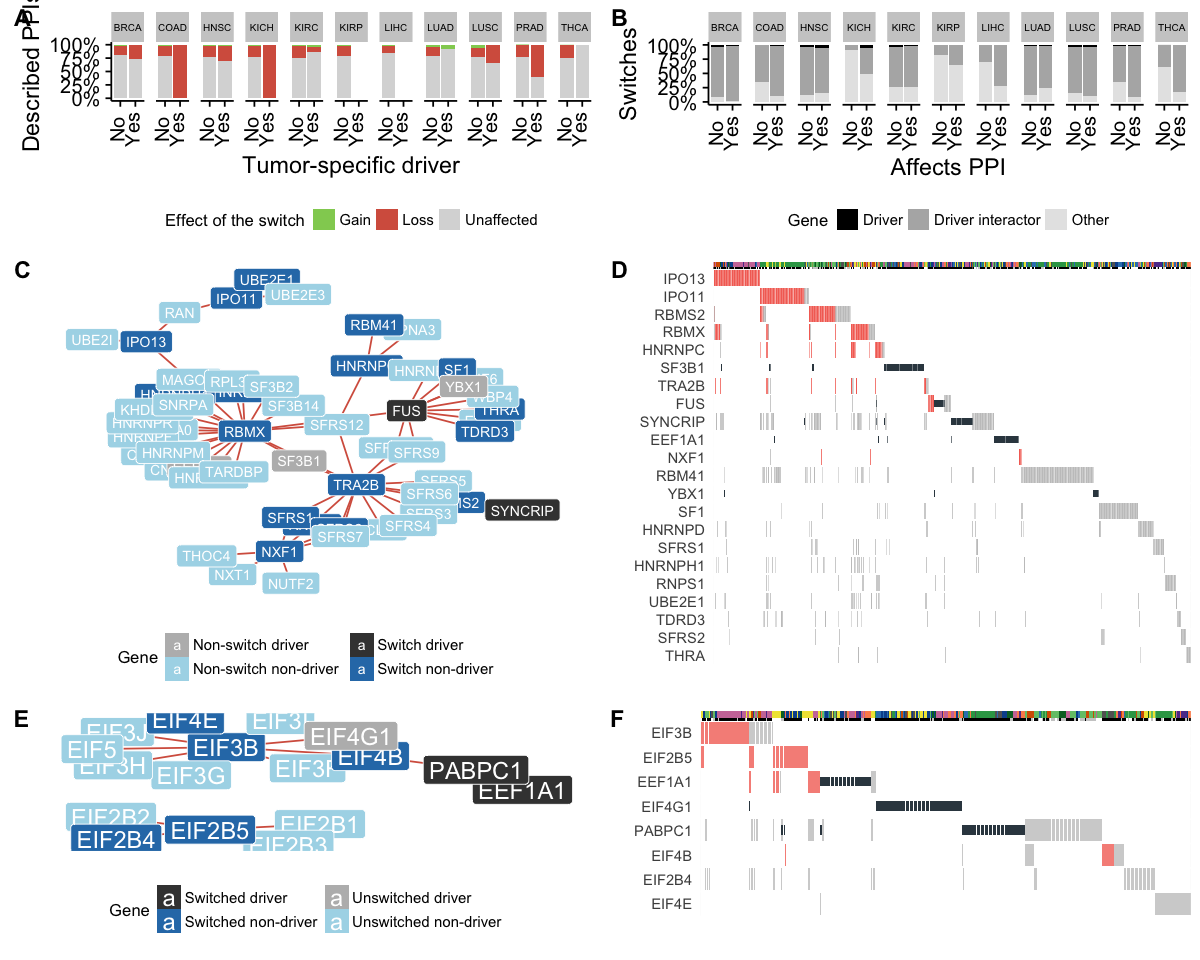

In [18]:
f3 <- cowplot::plot_grid(f3a, f3b, f3c, f3d, f3e, f3f, labels=c("A","B","C","D","E","F"), 
                         nrow = 3, ncol = 2, rel_heights = c(0.9, 1.6, 0.9))
f3
ggsave("../results/figures/figure_3.pdf", f3, width = 10, height = 13.75)

**Figure 3. Potential impact of isoform switches in protein interactions with cancer drivers.** (A) Functional switches were divided according to whether they occurred in tumor-specific drivers (yes) or not (no). For each tumor type we plot the proportion of protein-protein interactions (PPIs) (y axis) that were gained (green), lost (red), or remained unaffected (gray). All comparisons except for KIRC, LUAD were significant (Supplemental Experimental Procedures), Samples from KIRP and LIHC had no PPI-affecting switches in drivers. (B) Functional switches mapped to PPIs were divided according to whether they affected a PPI (yes) or not (no). For each tumor type we plotted the proportion of functional switches (y axis) that occurred in cancer drivers (black), in interactors of drivers (dark gray), or in other genes (light gray). All tests for the enrichment of PPIs affected by switches in drivers interactors were significant except for KIRC, LUAD and LUSC (Supplemental Experimental Procedures). (C) Network for module 11 (Table S6) with PPIs predicted to be lost (red). Cancer drivers are indicated in black or gray if they have a functional switch or not, respectively. Other genes are indicated in dark blue or light blue if they have a functional switch or not, respectively. We do not show unaffected interactions. (D) OncoPrint for the samples that present protein-affecting mutations (PAMs) in drivers or switches from (C). Mutations are indicated in black and PPI-affecting switches are indicated in red (loss in this case). Other switches with no predicted effect on the PPI are depicted in gray. The top panel indicates the tumor type of each sample by color (same color code as in previous figures). The second top panel indicates whether the sample harbors a PAM in a tumor-specific driver (black) or not (gray), or whether no mutation data is available for that sample (white). (E) As in (C) for module 28 (Table S6). (F) OncoPrint for the switches and drivers from (E). Colors are as in (D).

In [19]:
f4a <- switches.split %>%
    filter(Reliable == 1 & IsFunctional == 1) %>%
    mutate(Candidate = ifelse(Candidate == 1, "Yes", "No"),
           Tumor = toupper(Tumor)) %>%
    ggplot(aes(x = Tumor, fill = Candidate)) +
        geom_bar() +
        labs(fill = "Potential AS driver", y = "# functional switches") +
        scale_fill_manual(values=c("Yes"="#2e3268", "No" = "gray70")) +
        theme(axis.text.x = element_text(angle = 90, vjust = 0.3),
              legend.text=element_text(size=9),
              legend.title=element_text(size=10))
ggsave("../results/figures/components/4a.pdf", f4a)

Saving 7 x 7 in image


In [20]:
potus <- switches %>%
    filter(Candidate==1 & Origin=="Tumor") %>%
    select(GeneId,Symbol,Normal_transcript,Tumor_transcript)

# check that all the patients have at least one switch/mutation
alterationsPerPatient <- lapply(cancerTypes, function(tumor){
  
    # read switches
    tumor.potus <- switches.split %>%
        filter(Tumor==tumor) %>%
        merge(potus)
  
    ## count number of AS drivers switched per patient
    patients <- tumor.potus$Patients_affected %>% strsplit(",") %>% unlist
    switchesPerPatient <- plyr::count(patients) %>%
        set_colnames(c("Patient","Switches"))
  
    # read mutations  
    ## get cancer specific drivers
    tumor.drivers <- drivers$Symbol[drivers$Tumor==tumor]
   
    ## filter out mutations not in drivers
    mutations.drivers <- wes %>%
        filter(Tumor == tumor) %>%
        filter(Symbol %in% tumor.drivers) %>%
        ## consider only mutated genes, not several mutations in a gene
        select(GeneId,Patient) %>%
        unique
    
    ## count number of mutations per patient
    mutationsPerPatient <- plyr::count(mutations.drivers$Patient) %>%
        set_colnames(c("Patient","Mutations"))
    
    # get patients with both RNAseq and mutation information
    patients.swt <- unique(patients)
    patients.mut <- unique(wes$Patient)
    patients.common <- intersect(patients.swt,patients.mut)
    
    merge(mutationsPerPatient,switchesPerPatient, all=T) %>%
        mutate(Switches = ifelse(is.na(Switches), 0, Switches ),
               Mutations = ifelse(is.na(Mutations), 0, Mutations),
               Tumor = tumor,
               Class = ifelse(Mutations/length(tumor.drivers) < Switches/nrow(tumor.potus), "S", "M")) %>%
        filter(Patient %in% patients.common)
  
}) %>% do.call("rbind",.)

pdf("../results/figures/components/4b.pdf")
f4b <- switches %>%
    filter(Candidate==1) %>%
    select(Recurrence,Affects_mutated_feature,PPI,Pannegative) %>%
    rename(Affects_M_feature = Affects_mutated_feature) %>% 
    mutate(Pannegative = ifelse(Pannegative > 2, 1,0)) %>%
    as.data.frame %>%
    upset(order.by = "freq", nintersects = 9, line.size = 2.5, point.size = 7,
          mainbar.y.label = "# switches", sets.x.label = "# switches", show.numbers = FALSE,
          text.scale = c(2,2,2,2,2,1))
dev.off()

pdf 
  2

In [21]:
## Figure 4b
total <- alterationsPerPatient %>%
    plyr::count('Tumor') %>% 
    set_colnames(c("Tumor","Patients"))

tumorClassification <- alterationsPerPatient %>%
    plyr::count(c('Class','Tumor')) %>%
    set_colnames(c("Class","Tumor","Counts")) %>%
    merge(total) %>%
    mutate(Prop = Counts/Patients, Class = factor(Class, levels=c("S","M")),
           Tumor = toupper(Tumor),
           Tumor = factor(Tumor, levels=Tumor[Class=="S"][order(-Prop[Class=="S"])]))

f4c <- ggplot() + 
    geom_bar(data = subset(tumorClassification, Class=="S"),aes(x=Tumor,y=Prop,fill=Tumor),stat="identity") +
    geom_bar(data = subset(tumorClassification, Class=="M"),aes(x=Tumor,y=-Prop,fill=Tumor),stat="identity") +
    geom_text(aes(x=10,y=.85,label="Splicing"), size=5) +
    geom_text(aes(x=2,y=-.85,label="Mutations"), size=5) +
    geom_hline(yintercept = 0) +
    scale_fill_manual(values=colorPalette) +
    labs(y="Relevance", x="") +
    scale_y_continuous(labels = percent) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.4),
          legend.position="none")

ggsave("../results/figures/components/4c.pdf", f4c)

Saving 7 x 7 in image


In [22]:
## Figure 4d
f4d <- alterationsPerPatient %>%
    mutate(Tumor = toupper(Tumor)) %>%
    ggplot(aes(x=Switches,y=Mutations,color=Tumor)) + 
        geom_point(size=2) + 
        labs(x="AS-drivers switched",y="Mut-drivers mutated") +
        scale_color_manual(values=colorPalette) +
        theme(legend.text=element_text(size=9),
              legend.title=element_text(size=10))

ggsave("../results/figures/components/4d.pdf", f4d)

Saving 7 x 7 in image


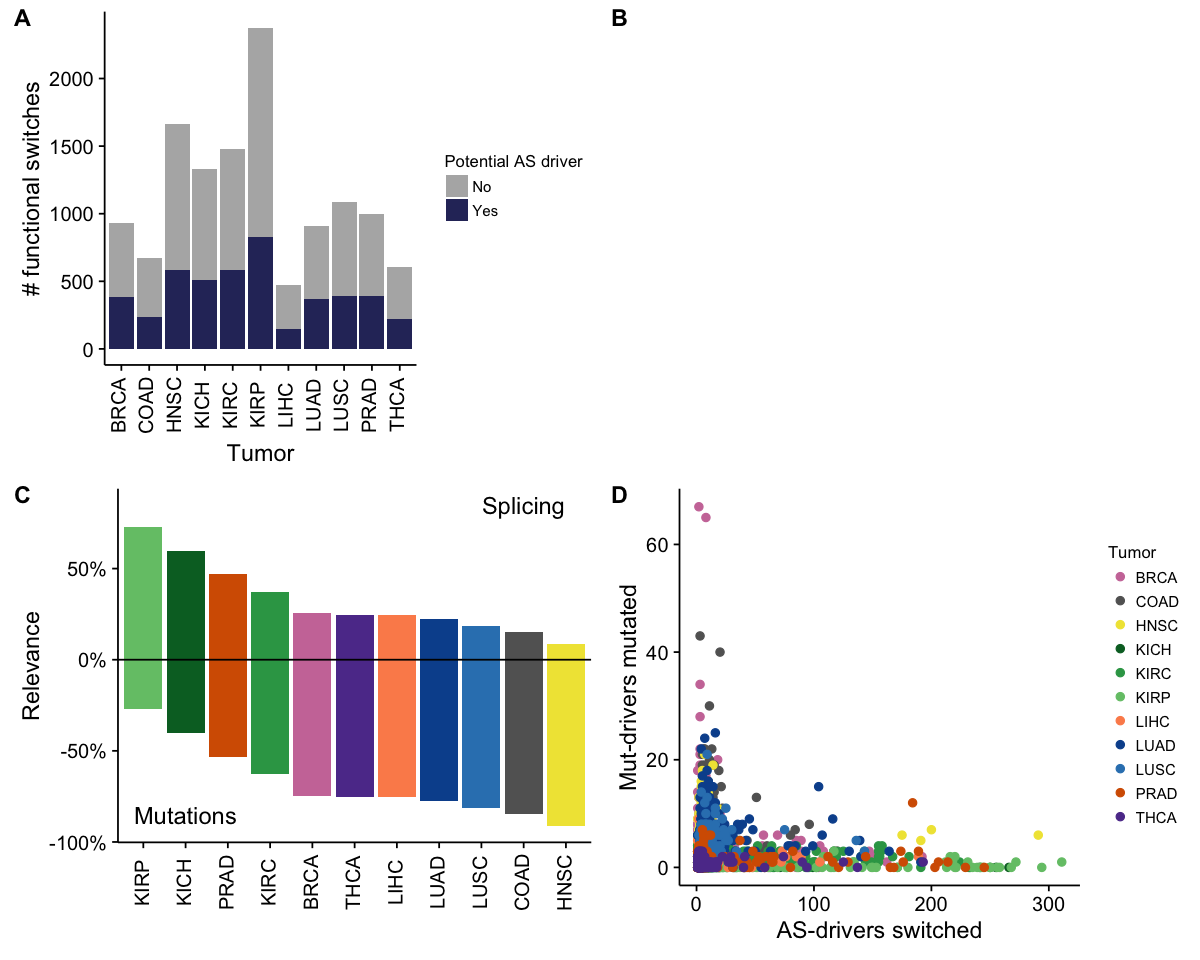

In [23]:
f4 <- cowplot::plot_grid(f4a, f4b, f4c, f4d, labels=c("A","B","C","D"))
f4
ggsave("../results/figures/components/figure_4_pre.pdf", f4, width = 10, height = 8)

**Figure 4. Isoform switches as potential drivers of cancer.** (A) Number of functional isoform switches and potential AS-drivers detected in each tumor type. (B) Candidate potential AS-drivers grouped according to their properties: disruption of protein–protein interactions (PPIs), significant recurrence across patients (Recurrence), gain or loss of a protein feature that is frequently mutated in tumors (Affects M_feature), mutual exclusion and sharing pathway with cancer drivers (Pannegative). Horizontal bars indicate the number of switches for each property. The vertical bars indicate those in each of the intersections indicated by connected bullet points (Conway et al., 2017). (C) Classification of samples according to the relevance of potential AS-drivers or Mut-drivers in each tumor type. For each tumor type (x axis), the positive y axis shows the percentage of samples that have a proportion of switched potential AS-drivers higher than the proportion of mutated Mut-drivers. The negative y axis shows the percentage of samples in which the proportion of mutated Mut-drivers is higher than the proportion of switched potential AS-drivers. Only patients with mutation and transcriptome data are shown. (D) Each of the patients from (C) is represented according to the percentage of mutated Mut-drivers (y axis) and the percentage of switched potential AS-drivers (x axis).